In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats 
import scipy.special
from scipy.special import comb
from scipy.optimize import minimize_scalar

import scipy
import math
import time
from sklearn.gaussian_process.kernels import RBF

from itertools import product, groupby
import random, time


In [2]:
def runs(a_list):
    runs_zeros = len([k for k, g in groupby(a_list) if k == 0])
    runs_ones = len([k for k, g in groupby(a_list) if k == 1])
    return runs_ones+runs_zeros

def tr(actions):
    if len(actions)<100:
        return 1
    else:
        return 1-0.02*(10-sum(actions[-10:-1]))/10

In [3]:
class T0_est:  
    def __init__(self, T, x, y,K,sigma,alpha,n_sim=10000,burn=0):
        self.T= T
        self.x=x
        self.y=y
        self.K=K
        self.sigma=sigma
        self.alpha=alpha
        self.n_sim=n_sim
        self.burn=burn
        self.n = y.shape[0]
        self.g = T.shape[0]
        
        self.T0_init = np.array([0, 1] * (self.g // 2))
        #self.T0_init = np.concatenate((np.ones(10),np.zeros(100),np.ones(18)))
        self.action = []
    
    def chain_builder(self):
        chain = [self.T0_init]
        for i in range(self.n_sim):
            curr=chain[-1]
            chain.append(self.next_T0(curr))
        return chain[self.burn:]
    
        
    def next_T0(self,current): 
        new = self.candidate(current)
        rate=self.acceptance_rate(current,new)
        
        treshold = tr(self.action)
        print(treshold)
        if rate>=treshold:
            print("Proposal T0 accepted with rate ", rate)
            self.action.append(1)
            return new
        
        else:
            print("Proposal T0 rejected with rate ", rate)
            self.action.append(0)
                
            return current
        
    def candidate(self,old):
        new=old.copy()
        coin = np.random.uniform(0,1,1)
        
        if coin<0.2: #split
            choices = [i for i in range(1,len(old) - 1) if old[i-1] == 1 and old[i] == 1 and old[i + 1] == 1]
            if len(choices)>0:
                choice = np.random.choice(choices)
                splitting_point = choice
                new[splitting_point]=0
        
        if (coin>=0.2) and (coin<0.4): #right removal
            choices = [i for i in range(0,len(old)-1) if old[i] == 1 and old[i + 1] == 0]
            if len(choices)>0:
                choice = np.random.choice(choices)
                removing_point = choice
                new[removing_point]=0
        
        if (coin>=0.4) and (coin<0.6): #left removal
            choices = [i+1 for i in range(0,len(old)-1) if old[i] == 0 and old[i + 1] == 1]
            if len(choices)>0:
                choice = np.random.choice(choices)
                removing_point = choice
                new[removing_point]=0
        
        if (coin>=0.6) and (coin<0.8): #right add
            choices = [i for i in range(1,len(old)) if old[i-1] == 1 and old[i] == 0]
            if len(choices)>0:
                choice = np.random.choice(choices)
                adding_point = choice
                new[adding_point]=1

        if coin>=0.8: #left add
            choices = [i for i in range(0,len(old)-1) if old[i] == 0 and old[i + 1] == 1]
            if len(choices)>0:
                choice = np.random.choice(choices)
                adding_point = choice
                new[adding_point]=1

        if sum(old)==0:
            choice = np.random.choice(range(len(old)))
            new[choice]=1
        return new
        
    
    def acceptance_rate(self,current,new):   
        prior = self.PT0(current)
        prior_new = self.PT0(new)
        likl = posterior(self.T,current,self.x,self.y,self.K,self.sigma).likelihood()
        likl_new =posterior(self.T,new,self.x,self.y,self.K,self.sigma).likelihood()
        
        return (likl_new*prior_new)/(likl*prior)
            
    
    def PT0(self,current): 
        r=runs(current)          
        return np.exp(-self.alpha*r)



# Class posterior:
The implementation of this class follows 007_2 notebook with the addition of **likelihood()** method which evaluates p(Y|T0)

In [4]:
class posterior:
    def __init__(self, T, T0, x, y, K,sigma):
        self.T = T
        self.x = x
        self.y = y
        self.n = y.shape[0]
        self.g = T.shape[0]
        self.T0 = T0
        self.sigma = sigma
        self.K = K
        self.K0 = self.get_K0()
        
    def get_K0(self):
        tau = np.where(self.T0==1)[0]
        K_tau=self.K[:, tau]
        K_tau_tau = self.K[tau[:, None], tau]
        return self.K- K_tau @ np.linalg.inv(K_tau_tau)@ K_tau.T              
        
    def Lx0(self,t):   
        L = np.zeros(self.n)    
        for i in np.arange(0,self.n):
            L[i] = np.trapz(self.K0[t, :] * self.x[i,:], self.T)
        return L
    
    def R0(self,i, j):
        Ri = np.trapz(self.K0[:, :] * self.x[i, :], self.T, axis=1)
        Rij = np.trapz(Ri * self.x[j, :],self.T)
        return Rij

    def M(self):
        return np.array([[self.R0(i, j) for j in range(self.n)] for i in range(self.n)])+np.identity(self.n)
    

    def likelihood(self): #p(Y|T0) 
        m_matrix = self.M()
        first = np.linalg.det(m_matrix) ** (-0.5)

        
        inv = np.linalg.inv(m_matrix)
        s11 = np.dot(np.dot(np.transpose(np.ones(self.n)),inv),np.ones(self.n))
        
        syy = np.dot(np.dot(np.transpose(self.y),inv),self.y)
        s1y = np.dot(np.dot(np.transpose(np.ones(self.n)),inv),self.y)
        b = 0.5*(syy-s1y**2/s11)
            
        return first/np.sqrt(s11)*(b**(-0.5*(n-1)))


## Example

In [5]:
g=128
T = np.linspace(-3,3,g)
T0_real = T[np.where((T >= -1) & (T <= 0.5))]

T0_01 = np.zeros(g)
for i in range(g):
    if (T[i]>=-1) and (T[i]<=0.5):
        T0_01[i]=1


step = T[1]-T[0]
n = 30
alpha = 4
sigma = 0.25

def integrate(T, f): 
    tot = 0;
    for i in range(len(T)-1):
        tot = tot + (1/2 * (f[i]+f[i+1]) * (T[1]-T[0]))
    return tot

def prior_kernel(s,t):
    return np.exp(-2*(t-s)**2)+0.0001*(s==t)

def proj(K,T,T0,f): 
    tau = np.where(T0==1)[0]
    K_tau=K[:, tau]
    K_tau_tau = K[tau[:, None], tau]
    beta_tau = f[tau] 
    
    proj = f-np.dot(K_tau,np.dot(np.linalg.inv(K_tau_tau),beta_tau))
    
    return proj

K = np.zeros((g, g))
K = np.fromfunction(np.vectorize(lambda s, t: prior_kernel(T[s], T[t])), (g, g), dtype=int) 
x = np.random.multivariate_normal(np.zeros(g), K, n)


In [6]:
beta = np.sin(T*math.pi/4)
beta0 = proj(K,T,T0_01,beta)

y = np.zeros(n)
y = np.fromfunction(np.vectorize(lambda i: integrate(T,  x[i,:]*beta0)+np.random.normal(0,sigma,1)), (n,), dtype=int)

In [7]:
post = T0_est(T, x, y, K, sigma, alpha, 1000)

chain = post.chain_builder()

1
Proposal T0 accepted with rate  2980.9177433431914
1
Proposal T0 rejected with rate  0.0003354671567952993
1
Proposal T0 accepted with rate  2981.2577741351774
1
Proposal T0 accepted with rate  2980.895636156647
1
Proposal T0 rejected with rate  0.0003354682417929226
1
Proposal T0 accepted with rate  2980.9321511044377
1
Proposal T0 accepted with rate  2981.2058701937676
1
Proposal T0 accepted with rate  2980.985217277756
1
Proposal T0 accepted with rate  2980.614141623583
1
Proposal T0 accepted with rate  2980.573755182761
1
Proposal T0 accepted with rate  2980.9689978357783
1
Proposal T0 accepted with rate  2980.9031700833657
1
Proposal T0 accepted with rate  2980.98018082947
1
Proposal T0 rejected with rate  0.000335465606402222
1
Proposal T0 accepted with rate  2980.787896680639
1
Proposal T0 rejected with rate  0.0003354817701432514
1
Proposal T0 accepted with rate  2980.8774619984765
1
Proposal T0 accepted with rate  2981.5008842579464
1
Proposal T0 accepted with rate  2981.341

0.99
Proposal T0 accepted with rate  1.0002895239479541
0.99
Proposal T0 accepted with rate  1.2450394488760883
0.99
Proposal T0 accepted with rate  1.0015371939328692
0.992
Proposal T0 accepted with rate  1.0018360944090536
0.994
Proposal T0 rejected with rate  0.9817877471807583
0.996
Proposal T0 rejected with rate  0.9452211946840702
0.994
Proposal T0 rejected with rate  0.9452211946840702
0.992
Proposal T0 accepted with rate  0.9998604057343822
0.992
Proposal T0 accepted with rate  1.0000043931705667
0.992
Proposal T0 accepted with rate  0.9999825782811417
0.992
Proposal T0 accepted with rate  1.3195741593073773
0.992
Proposal T0 accepted with rate  0.9998275857453462
0.992
Proposal T0 rejected with rate  0.7578076493910655
0.992
Proposal T0 rejected with rate  0.7578076493910655
0.99
Proposal T0 accepted with rate  2980.93942149481
0.99
Proposal T0 accepted with rate  1.0001735771916545
0.992
Proposal T0 accepted with rate  0.9995553332618229
0.994
Proposal T0 rejected with rate  

0.992
Proposal T0 accepted with rate  1.0000869345566463
0.992
Proposal T0 rejected with rate  0.00033552343967118445
0.992
Proposal T0 rejected with rate  0.930239083037944
0.99
Proposal T0 accepted with rate  1.0002535374934427
0.988
Proposal T0 accepted with rate  1.017760501693416
0.99
Proposal T0 accepted with rate  1.000770348197062
0.99
Proposal T0 rejected with rate  0.00033540243573121093
0.992
Proposal T0 accepted with rate  0.9987813579687218
0.99
Proposal T0 accepted with rate  0.9989370164181223
0.992
Proposal T0 accepted with rate  0.9985079354007135
0.992
Proposal T0 accepted with rate  1.0014942941827374
0.992
Proposal T0 accepted with rate  0.9995251175533079
0.994
Proposal T0 rejected with rate  0.0003354817428501716
0.996
Proposal T0 accepted with rate  1.0010457155094072
0.994
Proposal T0 rejected with rate  0.0003354711828171291
0.994
Proposal T0 accepted with rate  1.0020351940527525
0.992
Proposal T0 rejected with rate  0.00033546076665948117
0.994
Proposal T0 ac

0.982
Proposal T0 rejected with rate  0.9802801882776654
0.98
Proposal T0 rejected with rate  0.0003354110014520816
0.98
Proposal T0 accepted with rate  0.9802801882776654
0.98
Proposal T0 rejected with rate  0.9476550222663334
0.982
Proposal T0 rejected with rate  0.9411989263298538
0.982
Proposal T0 rejected with rate  0.9476550222663334
0.982
Proposal T0 rejected with rate  0.9411989263298538
0.982
Proposal T0 rejected with rate  0.9411989263298538
0.982
Proposal T0 rejected with rate  0.9476550222663334
0.982
Proposal T0 rejected with rate  0.5183378617816559
0.982
Proposal T0 accepted with rate  2.0872232040479513
0.982
Proposal T0 accepted with rate  1.0397717228762422
0.984
Proposal T0 rejected with rate  0.47004872373091905
0.984
Proposal T0 rejected with rate  0.00033550673784607976
0.984
Proposal T0 rejected with rate  0.9617495629076884
0.984
Proposal T0 accepted with rate  1.0367500232845053
0.984
Proposal T0 rejected with rate  0.9645526670276038
0.986
Proposal T0 rejected

0.988
Proposal T0 accepted with rate  0.9922105124209996
0.988
Proposal T0 accepted with rate  0.9915356925921522
0.988
Proposal T0 rejected with rate  0.0003351260638424537
0.988
Proposal T0 accepted with rate  1.0085365635055654
0.988
Proposal T0 rejected with rate  0.24462014735899887
0.99
Proposal T0 accepted with rate  0.9915356925921522
0.988
Proposal T0 accepted with rate  1.0085365635055654
0.99
Proposal T0 accepted with rate  0.9915356925921522
0.99
Proposal T0 rejected with rate  0.9757814615125376
0.992
Proposal T0 accepted with rate  1.0085365635055654
0.992
Proposal T0 rejected with rate  0.9752030429613456
0.992
Proposal T0 rejected with rate  0.9915356925921522
0.99
Proposal T0 accepted with rate  0.9915356925921522
0.99
Proposal T0 accepted with rate  7.02582943492703
0.99
Proposal T0 rejected with rate  0.9835385460846537
0.992
Proposal T0 rejected with rate  0.14233194945336528
0.99
Proposal T0 rejected with rate  0.0003353858052665142
0.988
Proposal T0 accepted with 

0.986
Proposal T0 rejected with rate  0.0003365757868984192
0.988
Proposal T0 accepted with rate  1.0078929399847993
0.988
Proposal T0 rejected with rate  0.934716538619394
0.988
Proposal T0 accepted with rate  1.0090984128328666
0.988
Proposal T0 rejected with rate  0.9714270125970444
0.99
Proposal T0 rejected with rate  0.9714270125970444
0.988
Proposal T0 rejected with rate  0.00033562245464774474
0.988
Proposal T0 accepted with rate  0.998569521439939
0.988
Proposal T0 rejected with rate  0.0003363562827746969
0.988
Proposal T0 rejected with rate  0.9846315953564619
0.986
Proposal T0 accepted with rate  1.0014325277603089
0.986
Proposal T0 accepted with rate  0.998569521439939
0.986
Proposal T0 rejected with rate  0.000335638911670036
0.988
Proposal T0 rejected with rate  0.0003353358368877257
0.986
Proposal T0 rejected with rate  0.0003353947179113709
0.986
Proposal T0 rejected with rate  0.9608047846560303
0.986
Proposal T0 rejected with rate  0.0003356915939822949
0.986
Proposal

0.99
Proposal T0 accepted with rate  0.9921688706491799
0.988
Proposal T0 accepted with rate  1.015608278990859
0.99
Proposal T0 rejected with rate  0.9846315953564619
0.992
Proposal T0 rejected with rate  0.9846315953564619
0.992
Proposal T0 accepted with rate  1.0014325277603089
0.99
Proposal T0 accepted with rate  0.998569521439939
0.99
Proposal T0 rejected with rate  0.9846315953564619
0.992
Proposal T0 accepted with rate  1.0014325277603089
0.99
Proposal T0 rejected with rate  0.9714270125970444
0.99
Proposal T0 accepted with rate  0.998569521439939
0.99
Proposal T0 rejected with rate  0.9608047846560303
0.99
Proposal T0 rejected with rate  0.9708585667652202
0.988
Proposal T0 rejected with rate  0.9608047846560303
0.988
Proposal T0 rejected with rate  0.9708585667652202
0.988
Proposal T0 rejected with rate  0.00033575597138127926
0.986
Proposal T0 rejected with rate  0.9708585667652202
0.984
Proposal T0 accepted with rate  0.9846315953564619
0.984
Proposal T0 accepted with rate  

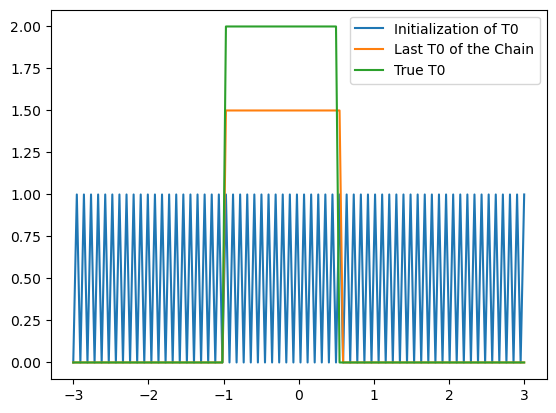

In [8]:
plt.plot(T,post.T0_init,label='Initialization of T0')
plt.plot(T,1.5*np.array(chain[-1]),label='Last T0 of the Chain')
plt.plot(T,2*T0_01,label='True T0')
plt.legend()

In [9]:
T0_hat, counts = stats.mode(chain, axis=0)
idxs = np.where(T0_hat==1)

C:\Users\Michele\AppData\Local\Temp\ipykernel_11004\2038631325.py:1: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  T0_hat, counts = stats.mode(chain, axis=0)


In [10]:
idxs

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64),
 array([ 43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,
         56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,
         69,  70,  71,  72,  73,  74, 119, 120, 121, 123, 124, 125],
       dtype=int64))

In [11]:
T[idxs[1][0]]

-0.9685039370078741